Libraries import

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
%matplotlib inline
from datetime import datetime
from datetime import date

Read the csv files

In [27]:
devices = pd.read_csv("data/devices.csv")
notifications = pd.read_csv("data/notifications.csv")
users = pd.read_csv("data/users.csv")
transactions = pd.read_csv("data/transactions_full.csv")

Dataset shapes

In [28]:
print("devices: ", devices.shape) 
print("notifications: ", notifications.shape) 
print("users: ", users.shape) 
print("transactions: ", transactions.shape)

devices:  (15544, 2)
notifications:  (97704, 5)
users:  (15544, 12)
transactions:  (2181026, 12)


In [29]:
# calculate difference between dates

def days_between(d1, d2='2019-05-17'):
    d1 = str(pd.to_datetime(d1, dayfirst=True))[:10]
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [30]:
# change Unknown brand based on the rest

def change_unknown_brand(brand):
    if brand == 'Unknown':
        return random.sample(['Android', 'Apple'], 1)[0]
    else:
        return brand

Dataset modifications and creation of base data table

In [31]:
data = users.merge(devices)
data['birth_year'] = data['birth_year'].apply(lambda x: 2020-x)
data['created_date'] = data['created_date'].apply(days_between)
data = data.drop(columns = ['num_referrals','num_successful_referrals','country','city', 'attributes_notifications_marketing_push', 'attributes_notifications_marketing_email'])
data = data.rename(columns={'birth_year':'age', 'created_date': 'reg_days', 'user_settings_crypto_unlocked':'crypto'})
plan_dict = {'STANDARD': 0, 'SILVER': 1, 'GOLD': 1}
data['plan'] = data['plan'].replace(plan_dict)
data['brand'] = data['brand'].apply(change_unknown_brand)
data = pd.get_dummies(data, columns=['brand'])

Notifications table modification

In [32]:
notifications = notifications[['status','user_id']]
notifications = notifications[~notifications['status'].isin(['FAILED'])]
notifications.drop(columns='status',inplace=True)
notifications = notifications['user_id'].value_counts().rename_axis('user_id').reset_index(name='notif_counts')

Transactions table modification

In [33]:
transactions = transactions[['user_id','amount_usd','transactions_state','direction', 'transactions_type']]
transactions = transactions[transactions['transactions_state'].isin(['COMPLETED'])]

In [34]:
t1 = transactions.pivot_table(index='user_id', columns='transactions_type',aggfunc='size', fill_value=0)

In [35]:
t2 = transactions.groupby(by=['user_id', 'direction'], as_index=False)['amount_usd'].sum()
t2 = t2.pivot(index='user_id', columns='direction', values='amount_usd')

In [36]:
t1['user_id'] = t1.index
t2['user_id'] = t2.index

t1.reset_index(drop=True, inplace=True)
t2.reset_index(drop=True, inplace=True)

In [37]:
transactions = t1.merge(t2, on = 'user_id')

In [38]:
data = data.set_index('user_id').join(transactions.set_index('user_id'))
data['user_id'] = data.index
data.reset_index(drop=True, inplace=True)
data = data.set_index('user_id').join(notifications.set_index('user_id'))

In [39]:
data.fillna(0, inplace=True)

In [40]:
data['SUM'] = data['INBOUND'] + data['OUTBOUND']

In [42]:
data = data.drop(columns = ['num_contacts','brand_Android','brand_Apple','INBOUND', 'OUTBOUND', 'notif_counts'])

In [44]:
data.reset_index(drop=True, inplace=True)

In [45]:
data

,age,reg_days,crypto,plan,ATM,CARD_PAYMENT,CARD_REFUND,CASHBACK,EXCHANGE,FEE,REFUND,TAX,TOPUP,TRANSFER,SUM
0,28,249,0,0,0.0,333.0,1.0,0.0,5.0,0.0,0.0,0.0,158.0,23.0,6925.08
1,35,491,1,0,4.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,27.0,12955.54
2,24,169,0,0,0.0,97.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,134.0,2723.90
3,39,454,0,0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,7.0,6999.29
4,28,494,0,0,0.0,37.0,1.0,0.0,4.0,0.0,0.0,0.0,8.0,0.0,981.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15539,23,285,0,0,1.0,42.0,1.0,0.0,13.0,1.0,0.0,0.0,32.0,1.0,4274.95
15540,35,414,0,0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,97.10
15541,42,308,0,0,0.0,534.0,0.0,0.0,5.0,1.0,0.0,0.0,77.0,445.0,17721.66
15542,43,495,0,1,0.0,7.0,0.0,7.0,0.0,4.0,0.0,0.0,3.0,2.0,408.72


### Clustering Algorithm

In [46]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X = sc.fit_transform(data.values)

for k in range(3,10):
    kmeans = KMeans(n_clusters = k, n_init=30, random_state=1000)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("For k =", k, "The average silhouette_score is :", silhouette_avg)

For k = 3 The average silhouette_score is : 0.40034418535590754
For k = 4 The average silhouette_score is : 0.4466105933382612
For k = 5 The average silhouette_score is : 0.46727296599942664
For k = 6 The average silhouette_score is : 0.4182690797786698
For k = 7 The average silhouette_score is : 0.39585097297244876
For k = 8 The average silhouette_score is : 0.3658947984315839
For k = 9 The average silhouette_score is : 0.36611961109940455


In [47]:
k_u = 5
kmeans_cust = KMeans(n_clusters = k_u, n_init=30, random_state=1000)
cust_clusters = kmeans_cust.fit_predict(X)

centroids = sc.inverse_transform(np.array(kmeans_cust.cluster_centers_))

pd.DataFrame(centroids, columns=data.columns[:]).round(2)

,age,reg_days,crypto,plan,ATM,CARD_PAYMENT,CARD_REFUND,CASHBACK,EXCHANGE,FEE,REFUND,TAX,TOPUP,TRANSFER,SUM
0,34.32,322.21,1.0,0.0,4.25,78.12,0.90,0.31,12.25,1.36,0.09,0.26,19.77,40.91,7093.53
1,36.50,212.65,0.0,-0.0,2.29,39.72,0.33,0.00,3.81,0.57,0.03,0.11,10.00,15.07,3709.67
2,36.60,394.57,0.0,-0.0,4.21,67.26,0.63,0.01,7.55,0.88,0.06,0.11,16.74,20.92,6457.20
3,39.84,282.36,-0.0,1.0,10.80,141.20,1.09,35.20,19.61,5.08,0.23,0.22,28.05,53.40,48193.32
4,36.31,328.33,1.0,1.0,13.23,195.30,1.58,67.16,33.92,7.24,0.52,0.35,42.40,101.91,35739.34


In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

centers_principalComponents = pca.fit_transform(kmeans_cust.cluster_centers_)
centers_principalDf = pd.DataFrame(data = centers_principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [49]:
print(centers_principalDf)

   principal component 1  principal component 2  principal component 3
0               0.129043               0.711707              -0.029783
1              -0.581724              -0.026237              -0.233547
2              -0.557281               0.015650               0.260531
3               0.150650              -0.711340              -0.015194
4               0.859312               0.010219               0.017993


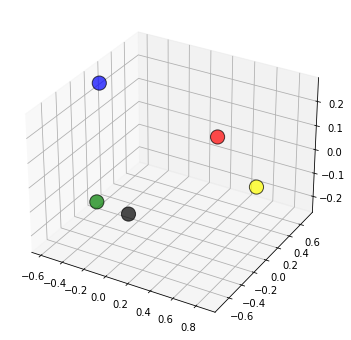

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

colors = np.array(['red', 'green', 'blue','black','yellow'])
x = centers_principalDf['principal component 1']
y = centers_principalDf['principal component 2']
z = centers_principalDf['principal component 3']

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=colors)
plt.show()